In [1]:
import sklearn
import nltk
import pandas as pd
import numpy as np
import os
import operator
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.pyplot import plot
nltk.download('stopwords') # If needed
nltk.download('punkt') # If needed
nltk.download('wordnet') # If needed
nltk.download('omw-1.4') # If needed

[nltk_data] Downloading package stopwords to C:\Users\Nathan
[nltk_data]     Hua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nathan
[nltk_data]     Hua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Nathan
[nltk_data]     Hua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Nathan
[nltk_data]     Hua\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Preprocessing

In [2]:
# Declaring a category map so that new categories can be added easily
CATEGORY_MAP = {
    "business": 1,
    "entertainment": 2,
    "politics": 3,
    "sport": 4,
    "tech": 5
}

In [3]:
# read all txt files in a directory and categorize them
def read_files(dir, category):
    result = []
    file_names = os.listdir(dir)
    for file_name in file_names:
        if ".txt" in file_name:
            file = open(dir + "/" + file_name)
            result.append([file.read(), category])
            file.close()
    return pd.DataFrame(result, columns=["content", "category"])

In [4]:
# read data
raw_data = []
for category, id in CATEGORY_MAP.items():
    raw_data.append(read_files("bbc/" + category, id))
full_set = pd.concat(raw_data, ignore_index=True)
full_set_x = full_set.iloc[: , :-1]
full_set_y = full_set.iloc[: , -1]

In [5]:
# split full data set into test, development, and test sets with ratio 8:1:1
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(full_set_x, full_set_y, test_size=0.2, random_state=1)
dev_set_x, test_set_x, dev_set_y, test_set_y = train_test_split(test_set_x, test_set_y, test_size=0.5, random_state=1)

# Feature Engineering and Feature Selection

## Feature 1: Category Word Frequency
Select n most frequent words of each category and combining them together to get our feature

In [6]:
# get the n most frequent words among a list of articles
stopwords = set(nltk.corpus.stopwords.words("english"))

# add additional_stopwords to stopwords. additional_stopwords are gathered through get_most_frequent_words
additional_stopwords = [".", ",", "'s", "``", "''", "'", "n't", "%", "-", "$", "(", ")", ":", ";"]
for sw in additional_stopwords: stopwords.add(sw)

# Initialize lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_most_frequent_words(article_list, n):
    # get all word frequencies, except stopwords
    dict_word_freq = {}
    for article in article_list:
        for sentence in nltk.tokenize.sent_tokenize(article):
            for token in nltk.tokenize.word_tokenize(sentence):
                word = lemmatizer.lemmatize(token).lower()
                if word in stopwords: continue
                if word in dict_word_freq: dict_word_freq[word] += 1
                else: dict_word_freq[word] = 1
    # sort and return first n words
    sorted_list = sorted(dict_word_freq.items(), key=operator.itemgetter(1), reverse=True)
    if len(sorted_list) <= n: return sorted_list
    else: return sorted_list[:n]

# get vector according to vocabulary from articles
def get_f1_vector(vocab, article):
    vector = np.zeros(len(vocab))
    words = []
    for sentence in nltk.tokenize.sent_tokenize(article):
        for token in nltk.tokenize.word_tokenize(sentence):
            words.append(lemmatizer.lemmatize(token).lower())
    
    for i, word in enumerate(vocab):
        if word in words:
            vector[i] = words.count(word)
    return vector

# prepare the training data for feature 1
# n is the number of most frequent words from a category
def prepare_f1_train_data(n):
    # Initialize vocabulary
    vocabulary=[]
    # create vocabulary for single keyword frequency count
    for id in CATEGORY_MAP.values():
        temp_list = []
        for i in train_set_x.index:
            if train_set_y.loc[i] == id:
                temp_list.append(train_set_x.loc[i, "content"])
        for word, frequency in get_most_frequent_words(temp_list, n):
            if word not in vocabulary: vocabulary.append(word)
    # print(str(len(vocabulary)) + ": " + str(vocabulary))

    # create training data
    x = []
    y = []
    for i in train_set_x.index:
        x.append(get_f1_vector(vocabulary, train_set_x.loc[i, "content"]))
        y.append(train_set_y.loc[i])
    return np.asarray(x), np.asarray(y), vocabulary

## Feature 2: Title Words Frequency  
Observing that every first line of an article is its title, I guess title's word frequency can be used for classifying an article.

In [7]:
# get vector according to vocabulary from article title
def get_f2_vector(vocab, article):
    vector = np.zeros(len(vocab))
    words = []
    for token in nltk.tokenize.word_tokenize(nltk.tokenize.sent_tokenize(article)[0]):
        words.append(lemmatizer.lemmatize(token).lower())
    for i, word in enumerate(vocab):
        if word in words:
            vector[i] = words.count(word)
    return vector

def prepare_f2_train_data():
    # prepare the title vocabulary
    title_vocab = []
    for i in train_set_x.index:
        article = train_set_x.loc[i, "content"]
        # only words in the first line of an article need to be count
        for token in nltk.tokenize.word_tokenize(nltk.tokenize.sent_tokenize(article)[0]):
            word = lemmatizer.lemmatize(token).lower()
            if word in stopwords: continue
            if word not in title_vocab: title_vocab.append(word)
    # create training data
    x = []
    y = []
    for i in train_set_x.index:
        x.append(get_f2_vector(title_vocab, train_set_x.loc[i, "content"]))
        y.append(train_set_y.loc[i])
    return np.asarray(x), np.asarray(y), title_vocab

## Feature 3: TF-IDF

In [8]:
# Initialize Tfidf Vectorizer
tfidf_vector = TfidfVectorizer()
# Learn vocabulary and idf from training set
tfidf_vector.fit(train_set_x["content"])
# Transform train and test input documents to document-term matrix
tfidf_train_x = tfidf_vector.transform(train_set_x["content"])
tfidf_test_x  = tfidf_vector.transform(test_set_x["content"])

# Linear Classifier Training, Validation, and Overall Performance

In [9]:
# Create Linear Classifier instance
svm_clf_category = sklearn.svm.SVC(kernel="linear", gamma='auto')
# Create Scores Variables
pre, rec, f1, acc = 0, 0, 0, 0

# Print all scores
def print_scores():
    print("Precision:\t" + str(pre))
    print("Recall:\t\t" + str(rec))
    print("F1:\t\t" + str(f1))
    print("Accuracy:\t" + str(acc))
    
# validation function
def validation(model, vocabulary, get_vector, set_x, set_y, select_k=None):
    x = []
    y = []
    for i in set_x.index:
        x.append(get_vector(vocabulary, set_x.loc[i, "content"]))
        y.append(set_y.loc[i])

    # if used chi-squared to select k best, transform the data
    if select_k != None:
        x = select_k.transform(x)
        
    predictions = model.predict(x)
    y = np.asarray(y)
    
    precision = precision_score(y, predictions, average='macro')
    recall    = recall_score(y, predictions, average='macro')
    f1        = f1_score(y, predictions, average='macro')
    accuracy  = accuracy_score(y, predictions)
    return precision, recall, f1, accuracy

## Feature 1 training and testing

Precision:	0.9062450123142126
Recall:		0.9009610245332105
F1:		0.9023387981634763
Accuracy:	0.9009009009009009


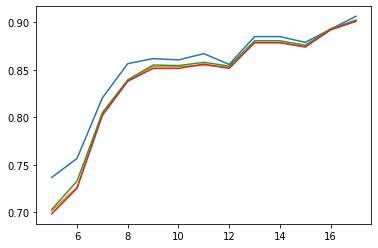

In [10]:
# use development set to adjust n to get an acceptable score: f1 >= 0.9
# this step seems need to restart the kernel if rerun with no change,
# or it will only get the last n and its corresponding result and cannot plot correctly
n = 5
vocab_f1 = []
plt_x = []
plt_y = []
while f1 < 0.9:
    train_f1_x, train_f1_y, vocab_f1 = prepare_f1_train_data(n)
    svm_clf_category.fit(train_f1_x, train_f1_y)
    pre, rec, f1, acc = validation(svm_clf_category, vocab_f1, get_f1_vector, dev_set_x, dev_set_y)
    plt_x.append(n)
    plt_y.append([pre, rec, f1, acc])
    n += 1
plot(plt_x, plt_y)
print_scores()

In [11]:
# Testing using the test set to get the overall performance
pre, rec, f1, acc = validation(svm_clf_category, vocab_f1, get_f1_vector, test_set_x, test_set_y)
print_scores()

Precision:	0.8854794038387505
Recall:		0.8803162915237218
F1:		0.8799756938868152
Accuracy:	0.8834080717488789


## Feature 2 training and Testing

Precision:	0.9112766227023051
Recall:		0.9040976016358535
F1:		0.9058310955402826
Accuracy:	0.9054054054054054


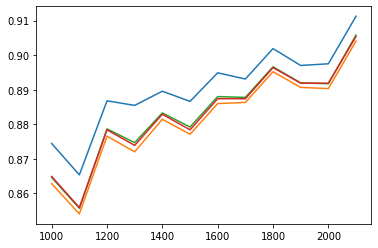

In [12]:
# use development set to validate if this feature is good enough
train_f2_x, train_f2_y, vocab_f2 = prepare_f2_train_data()

# clear data
f1 = 0
plt_x = []
plt_y = []
k_value = 1000
while f1 < 0.9:
    # feature selection with chi-squared test method
    select_k = SelectKBest(chi2, k=k_value).fit(train_f2_x, train_f2_y)
    train_f2_x_new = select_k.transform(train_f2_x)
    svm_clf_category.fit(train_f2_x_new, train_f2_y)
    pre, rec, f1, acc = validation(svm_clf_category, vocab_f2, get_f2_vector, dev_set_x, dev_set_y, select_k)
    plt_x.append(k_value)
    plt_y.append([pre, rec, f1, acc])
    k_value += 100
plot(plt_x, plt_y)
print_scores()

In [13]:
# Test the overall performance
pre, rec, f1, acc = validation(svm_clf_category, vocab_f2, get_f2_vector, test_set_x, test_set_y, select_k)
print_scores()

Precision:	0.9113436561336055
Recall:		0.9064021141884918
F1:		0.9068283621086903
Accuracy:	0.9103139013452914


## Feature 3 training and Testing

In [15]:
# Train the classifier
svm_clf_category.fit(tfidf_train_x, train_set_y.to_numpy())
# Test with test data
predictions = svm_clf_category.predict(tfidf_test_x)
tfidf_test_y = test_set_y.to_numpy()
    
pre = precision_score(tfidf_test_y, predictions, average='macro')
rec = recall_score(tfidf_test_y, predictions, average='macro')
f1  = f1_score(tfidf_test_y, predictions, average='macro')
acc = accuracy_score(tfidf_test_y, predictions)
print_scores()

Precision:	0.9750257997936018
Recall:		0.9764956907371769
F1:		0.9757120286400541
Accuracy:	0.9775784753363229
